In [15]:
import os
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Define dataset path
dataset_path = "dataset"

# Define categories
health_categories = ["Strawberry__healthy", "healthy", "healthy_weeds", "Strawberry___Leaf_scorch", "unhealthy", "unhealthy_weeds"]
weed_categories = ["healthy_weeds", "unhealthy_weeds", "healthy", "unhealthy", "Strawberry__healthy", "Strawberry___Leaf_scorch"]

# Health Labels (1 = Healthy, 0 = Unhealthy)
health_labels = {cat: 1 if "healthy" in cat else 0 for cat in health_categories}

# Weed Labels (1 = Weed, 0 = No Weed)
weed_labels = {cat: 1 if "weeds" in cat else 0 for cat in weed_categories}

# ✅ Check if all folders exist
missing_folders = [folder for folder in health_categories if not os.path.exists(os.path.join(dataset_path, folder))]

if missing_folders:
    print(f"⚠️ Warning: The following folders are missing: {missing_folders}")
else:
    print("✅ All dataset folders exist!")

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Image data generator with rescaling and augmentation
datagen = ImageDataGenerator(
    rescale=1./255, validation_split=0.2,
    rotation_range=20, zoom_range=0.2, horizontal_flip=True  # Augmentations
)

# Load training and validation data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,  # No automatic labels
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,  # No automatic labels
    subset="validation",
    shuffle=True
)

# Custom generator to assign multi-label targets dynamically
def custom_multi_label_generator(generator):
    while True:
        images = next(generator)
        batch_size = images.shape[0]  # Ensure we match batch size

        # Extract folder names from filenames to determine labels
        labels = []
        for filepath in generator.filenames[:batch_size]:  # Match correct batch
            folder_name = filepath.split(os.sep)[0]  # Extract category
            health_label = health_labels.get(folder_name, 0)  # Default to 0 if missing
            weed_label = weed_labels.get(folder_name, 0)  # Default to 0 if missing
            labels.append([health_label, weed_label])

        yield images, np.array(labels)

# Wrap generators
train_multi_label_generator = custom_multi_label_generator(train_generator)
val_multi_label_generator = custom_multi_label_generator(val_generator)

# Compute class weights
y_train_health = [health_labels[folder] for folder in health_labels]
y_train_weed = [weed_labels[folder] for folder in weed_labels]

health_class_weights = compute_class_weight("balanced", classes=np.unique(y_train_health), y=y_train_health)
weed_class_weights = compute_class_weight("balanced", classes=np.unique(y_train_weed), y=y_train_weed)

health_class_weights_dict = {i: health_class_weights[i] for i in range(len(health_class_weights))}
weed_class_weights_dict = {i: weed_class_weights[i] for i in range(len(weed_class_weights))}

# Build multi-label CNN model
def build_multi_label_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='sigmoid')  # Multi-label classification
    ])
    return model

# Build and compile model
model = build_multi_label_cnn()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
start_time = time.time()
history = model.fit(
    train_multi_label_generator,
    validation_data=val_multi_label_generator,
    epochs=15,
    steps_per_epoch=len(train_generator),  # Ensure steps match generator size
    validation_steps=len(val_generator)
)
end_time = time.time()

print(f"✅ Training completed in {end_time - start_time:.2f} seconds ({(end_time - start_time)/60:.2f} minutes)")


✅ All dataset folders exist!
Found 1182 images belonging to 7 classes.


Found 293 images belonging to 7 classes.
Epoch 1/15
37/37 [==============================] - 53s 1s/step - loss: 0.0191 - accuracy: 0.3816 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
37/37 [==============================] - 50s 1s/step - loss: 0.0000e+00 - accuracy: 0.3866 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/15
37/37 [==============================] - 49s 1s/step - loss: 6.4753e-16 - accuracy: 0.4019 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/15
37/37 [==============================] - 50s 1s/step - loss: 2.0262e-36 - accuracy: 0.4129 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/15
37/37 [==============================] - 49s 1s/step - loss: 0.0000e+00 - accuracy: 0.4044 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/15
37/37 [==============================] - 50s 1s/step - loss: 0.0000e+00 - accuracy: 0.4095 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/15
37/37 [==============================] -

⚠️ No images found in 'Strawberry__healthy', skipping.
1/1 [==============================] - 0s 26ms/step


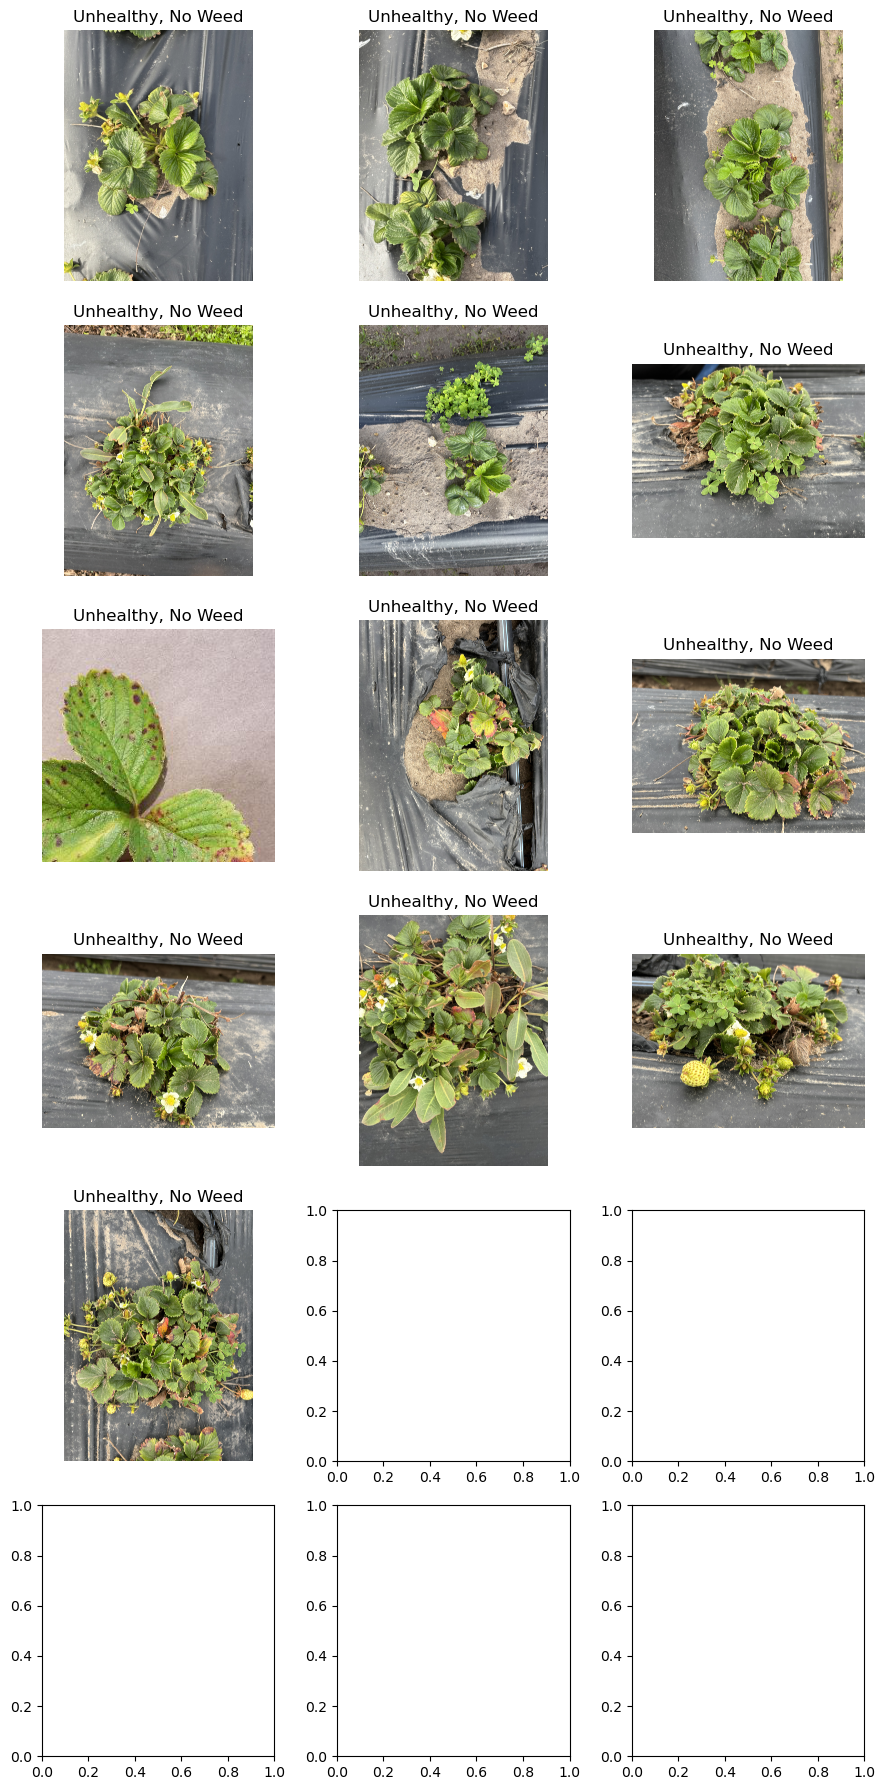

In [16]:
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Number of images to sample per category
x = 3  # Adjust as needed

# Function to load random images from each folder
def load_random_images(dataset_path, categories, num_images):
    selected_images = []
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path):
            print(f"⚠️ Warning: Folder '{category}' does not exist, skipping.")
            continue
        
        # Filter out non-image files
        images = [f for f in os.listdir(category_path) if f.endswith(".jpg")]
        if not images:
            print(f"⚠️ No images found in '{category}', skipping.")
            continue

        sampled_images = random.sample(images, min(num_images, len(images)))
        for img_name in sampled_images:
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Warning: Could not read image {img_name}, skipping.")
                continue

            img_resized = cv2.resize(img, (224, 224)) / 255.0  # Normalize
            selected_images.append((category, img_name, img, img_resized))

    return selected_images

# Load `x` random images from each category
random_samples = load_random_images(dataset_path, health_labels.keys(), x)

# Check if we have images
if not random_samples:
    print("❌ No valid images found. Check dataset structure.")
else:
    # Display images with predictions
    rows = len(health_labels.keys())
    cols = min(x, len(random_samples))  # Adjust columns to available images
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    for i, (category, img_name, img, img_resized) in enumerate(random_samples):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]

        # Run model prediction
        img_input = np.expand_dims(img_resized, axis=0)
        class_pred = model.predict(img_input)[0]

        # Convert predictions to labels
        health_pred = "Healthy" if class_pred[0] >= 0.5 else "Unhealthy"
        weed_pred = "Weed" if class_pred[1] >= 0.5 else "No Weed"

        # Show image with predictions
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(f"{health_pred}, {weed_pred}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()
